# Simulating the 100 Prisoners Riddle


In [1]:
import pandas as pd
import numpy as np
from tqdm import trange
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
color_pal = sns.color_palette(n_colors=50)

In [2]:
def shuffle_boxes():
    prisoner_numbers = [x for x in range(0, 100)]
    boxes = {}
    np.random.shuffle(prisoner_numbers)
    for i, p in enumerate(prisoner_numbers):
        boxes[i] = p
    return boxes


PRISONERS = [x for x in range(0, 100)]
BOX_NUMBERS = [x for x in range(0, 100)]

# Random choice strategy

In [3]:
def random_strategy(prisoner_number, boxes):
    """
    Randomly select 50 boxes for the prisoner.

    Returns True if they found their number, False if they did not
    """
    prisoner_choices = np.random.choice(BOX_NUMBERS, size=50, replace=False)
    for choice in prisoner_choices:
        if boxes[choice] == prisoner_number:
            return True
    return False

## Simulate the strategy

In [4]:
results = {}
for sim in trange(5_000):
    boxes = shuffle_boxes()
    n_correct = 0
    for prisoner in PRISONERS:
        correct = random_strategy(prisoner_number=prisoner, boxes=boxes)
        if correct:
            n_correct += 1
    results[sim] = n_correct

100%|██████████| 5000/5000 [00:38<00:00, 128.87it/s]


In [5]:
# Create Dataframe with results
results_random = pd.DataFrame.from_dict(results, orient="index", columns=["ncorrect"])

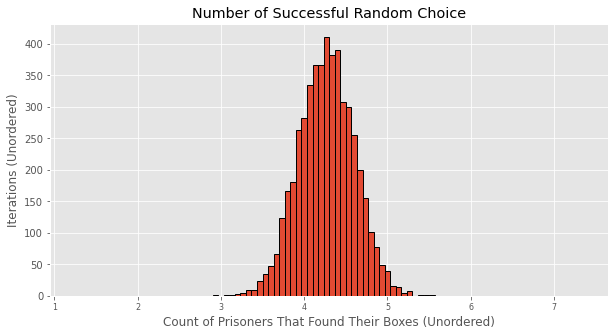

In [6]:
results_agg = pd.DataFrame(index=range(1, 101))
results_agg["counts"] = results_agg.index.map(
    results_random["ncorrect"].value_counts().to_dict()
).fillna(0)

ax = results_agg.plot(
    kind="bar",
    figsize=(10, 5),
    width=1,
    lw=1,
    edgecolor="black",
    title="Number of Successful Random Choice",
)

ax.set_xticklabels(ax.get_xticks(), rotation=0, size=8)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xlabel("Count of Prisoners That Found Their Boxes (Unordered)")
plt.ylabel("Iterations (Unordered)")
ax.legend().remove()

plt.show()

In [7]:
# Odds of success
(0.5) ** 100

7.888609052210118e-31

In [8]:
0.00000000000000000000000000000078

7.8e-31

# Loop Strategy


In [9]:
def loop_strategy(prisoner_number, boxes):
    next_box = prisoner_number
    for x in range(50):
        if boxes[next_box] == prisoner_number:
            return True
        next_box = boxes[next_box]
    return False

In [10]:
def try_strategy(boxes, strategy):
    n_correct = 0
    for prisoner in PRISONERS:
        correct = strategy(prisoner_number=prisoner, boxes=boxes)
        if correct:
            n_correct += 1
    return n_correct

In [11]:
results = {}
Num = 5000
all_prisoner_success_count = 0
approximation = []

for sim in trange(Num):
    boxes = shuffle_boxes()
    n_correct = 0
    for prisoner in PRISONERS:
        correct = loop_strategy(prisoner_number=prisoner, boxes=boxes)
        if correct:
            n_correct += 1
    if n_correct == 100:
      all_prisoner_success_count += 1
    approximation.append((all_prisoner_success_count/Num))
      
    results[sim] = n_correct

# Create Dataframe with results

results_loop = pd.DataFrame.from_dict(results, orient="index", columns=["ncorrect"])


100%|██████████| 5000/5000 [00:02<00:00, 1775.52it/s]


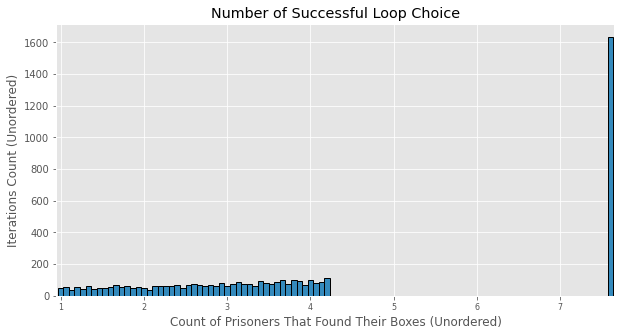

In [12]:
results_agg = pd.DataFrame(index=range(0, 100))
results_agg.index += 1

results_agg["counts"] = results_agg.index.map(
    results_loop["ncorrect"].value_counts().to_dict()
).fillna(0)

ax = results_agg.plot(
    kind="bar",
    color=color_pal[1],
    figsize=(10, 5),
    width=1,
    lw=1,
    edgecolor="black",
    title="Number of Successful Loop Choice",
)

ax.set_xticklabels(ax.get_xticks(), rotation=0, size=8)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xlabel("Count of Prisoners That Found Their Boxes (Unordered)")
plt.ylabel("Iterations Count (Unordered)")
ax.legend().remove()


plt.show()

# Monte Carlo Approach


0.327


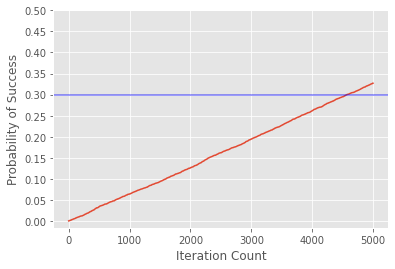

In [24]:
print((results_loop["ncorrect"] == 100).mean())

plt.clf()
accuracy_plot = plt.subplot()
accuracy_plot.plot(approximation)
accuracy_plot.axhline(0.3, color="b", alpha=0.5);
accuracy_plot.set_yticks([0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
accuracy_plot.set_xlabel("Iteration Count")
accuracy_plot.set_ylabel("Probability of Success")
plt.show()

# How Does it work?
- Boxes are "linked" to each other.
- You can think of this in terms of a graph network where the boxes are nodes and the paper is an edge.
- The graph consists of any number of "loops".
- By starting with their own number the prisoner is guaranteed to be in their own loop.
- If the largest "loop" within the graph is less than 50, all prisoners will succeed


In [14]:
boxes = shuffle_boxes()
G = nx.DiGraph()
G.add_nodes_from(PRISONERS)

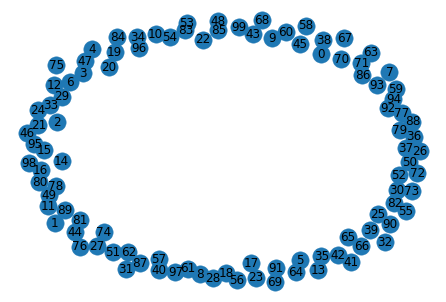

In [15]:
nx.draw(G, with_labels=True)
plt.show()

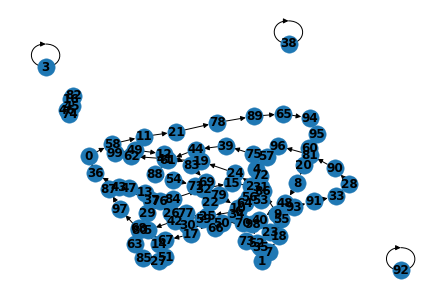

In [16]:
edges = [(x, y) for x, y in boxes.items()]
G.add_edges_from(edges, weight=1)
nx.draw(G, with_labels=True, font_weight="bold")

## Coloring The loops

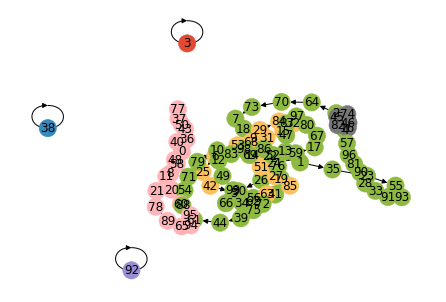

In [17]:
node_loop = {}
loops = nx.simple_cycles(G)

for loop, nodes in enumerate(loops):
    for node in nodes:
        node_loop[node] = loop
loop_df = pd.DataFrame.from_dict(node_loop, orient="index", columns=["loop"])

loop_df["color"] = loop_df["loop"].apply(lambda x: color_pal[x])
loop_df = loop_df.sort_index()

pos = None
# pos = nx.layout.fruchterman_reingold_layout(G)
# pos = nx.layout.kamada_kawai_layout(G)
nx.draw(G, pos, node_color=loop_df["color"].values, with_labels=True)
plt.show()

In [18]:
largest_loop = loop_df['loop'].value_counts().max()
print(f'Largest loop is size {largest_loop}')

Largest loop is size 57


In [19]:
# Add colors to node
loops = nx.simple_cycles(G)
for node, loop in loop_df["loop"].to_dict().items():
    G.nodes[node]["loop"] = str(loop)
    G.nodes[node]["label"] = node

# Create Graph from Boxes

In [20]:
def create_graph(boxes):
    G = nx.DiGraph()
    G.add_nodes_from(PRISONERS)
    edges = [(x, y) for x, y in boxes.items()]
    G.add_edges_from(edges, weight=1)
    node_loop = {}
    loops = nx.simple_cycles(G)

    for loop, nodes in enumerate(loops):
        for node in nodes:
            node_loop[node] = loop
    loop_df = pd.DataFrame.from_dict(node_loop, orient="index", columns=["loop"])

    loop_df["color"] = loop_df["loop"].apply(lambda x: color_pal[x])
    loop_df = loop_df.sort_index()
    # Add colors to node
    for node, loop in loop_df["loop"].to_dict().items():
        G.nodes[node]["group"] = str(loop)
        G.nodes[node]["loop_key"] = loop
        G.nodes[node]["label"] = str(node)
    return G, loop_df

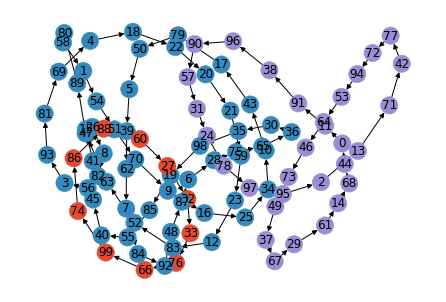

In [21]:
boxes = shuffle_boxes()
G, loop_df = create_graph(boxes)
nx.draw(G, with_labels=True, node_color=loop_df["color"].values)